In [1]:
import pandas as pd
import pybedtools
from ALLCools.mcds import MCDS
import glob
import joblib

In [2]:
gene_meta_path = '/home/qzeng/project/aging/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
chrom_to_remove = ['chrM','chrY']

# change this to the path to your filtered metadata
metadata_path = '/home/qzeng/project/aging/metadata/240104_mC_META.csv'

# change this to the paths to your MCDS files
obs_dim = 'cell'
var_dim = 'geneslop2k'

min_cov = 5

male_cemba_mcds_paths = glob.glob('/gale/netapp/home/wtian/aging/dataset/cemba/mcds/*.mcds') 
male_aging_mcds_paths = glob.glob('/gale/netapp/home/wtian/aging/dataset/aging/mcds/*.mcds') 
mcds_path = list(male_cemba_mcds_paths) + list(male_aging_mcds_paths)

In [3]:
!pwd

/home/qzeng/project/aging/240518_redo_aDMG


In [4]:
metadata = pd.read_csv(metadata_path, index_col = 0)

gene_name_to_id = joblib.load('240112_DMG_CEF/gene_name_to_id_dict')
gene_id_to_name = joblib.load('240112_DMG_CEF/gene_id_to_name_dict')

gene_meta = pd.read_csv(gene_meta_path, index_col ='gene_id', sep='\t')

/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## prepare male gene MCDS

In [5]:
genes_to_skip = set()

# skip smaller genes mostly covered by a larger gene, e.g., a miRNA within a protein coding gene.
# F=0.9 means > 90% of gene_b is overlapped with gene_a, in this case, we only keep gene_a for DMG test
# gene_bed = pybedtools.BedTool.from_dataframe(
#     gene_meta.reset_index()[['chrom', 'start', 'end', 'gene_id']])
# mapped_bam = gene_bed.map(b=gene_bed, c=4, o='distinct', F=0.9)
# for _, (*_, gene_a, gene_b_str) in mapped_bam.to_dataframe().iterrows():
#     for gene_b in gene_b_str.split(','):
#         if gene_b != gene_a:
#             genes_to_skip.add(gene_b)

# remove certain chromosomes
genes_to_skip |= set(gene_meta.index[gene_meta['chrom'].isin(chrom_to_remove)])
use_features = gene_meta.index[~gene_meta.index.isin(genes_to_skip)]
print(f'{use_features.size} features remained')

53881 features remained


In [6]:
mcds = MCDS.open(mcds_path, 
                 var_dim=var_dim,
                 use_obs=metadata.index
                )

In [7]:
all_ = mcds.get_index(var_dim)

In [8]:
use_features = list(set(mcds.get_index(var_dim)) & set(use_features))
len(use_features)

53881

In [9]:
joblib.dump(use_features,'tmp_use_features')

['tmp_use_features']

## select features

In [10]:
mcds = MCDS.open(mcds_path, 
                 var_dim= var_dim,
                 use_obs=metadata.index)

Feature geneslop2k mean cov across cells added in MCDS.coords['geneslop2k_cov_mean'].


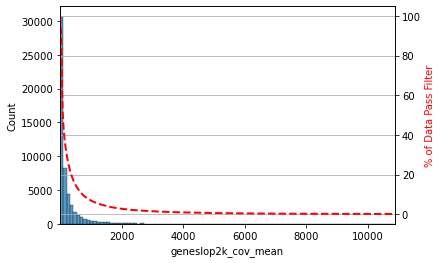

In [11]:
mcds.add_feature_cov_mean()

In [12]:
feature_cov_mean = mcds.coords[f'{var_dim}_cov_mean'].to_pandas()

In [13]:
use_features_2 = feature_cov_mean[feature_cov_mean > min_cov].index

In [14]:
mcds.filter_feature_by_cov_mean(min_cov=min_cov)

Before cov mean filter: 55487 geneslop2k
 After cov mean filter: 53533 geneslop2k 96.5%


,Array,Chunk
Bytes,107.72 GiB,2.41 GiB
Shape,"(132551, 27269, 2, 2)","(2967, 27269, 2, 2)"
Count,490 Tasks,75 Chunks
Type,int64,numpy.ndarray
,Array,Chunk
Bytes,211.47 GiB,4.73 GiB
Shape,"(132551, 53533, 2, 2)","(2967, 53533, 2, 2)"
Count,565 Tasks,75 Chunks
Type,int64,numpy.ndarray


In [15]:
use_features_1 = joblib.load('tmp_use_features')

In [16]:
use_features = list(set(use_features_1) & set(use_features_2))
len(use_features)

53088

In [17]:
f_mcds = mcds.sel(geneslop2k = mcds.get_index(var_dim).isin(use_features))

/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [18]:
f_mcds.add_mc_frac(normalize_per_cell=False, clip_norm_value=None)

In [19]:
f_mcds = f_mcds[['geneslop2k_da_frac']]
f_mcds['geneslop2k_da_frac'] = f_mcds['geneslop2k_da_frac'].astype('float32')

In [21]:
f_mcds.write_dataset(f'Male.genes_frac.mcds', var_dims=['geneslop2k'])

Saving geneslop2k
Saving chunk 0: 0 - 10000


/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Saving chunk 1: 10000 - 20000
Saving chunk 2: 20000 - 30000
Saving chunk 3: 30000 - 40000
Saving chunk 4: 40000 - 50000
Saving chunk 5: 50000 - 60000
Saving chunk 6: 60000 - 70000
Saving chunk 7: 70000 - 80000
Saving chunk 8: 80000 - 90000
Saving chunk 9: 90000 - 100000
Saving chunk 10: 100000 - 110000
Saving chunk 11: 110000 - 120000
Saving chunk 12: 120000 - 130000
Saving chunk 13: 130000 - 132551


In [ ]:
# mcds = MCDS.open(mcds_path, 
#                  var_dim= use_features.isin(mcds.get_index(var_dim)),
#                  use_obs=metadata.index).sel({var_dim: use_features})